In [1]:
# # DeepFake Detection - Optimized for Tesla T4 GPU

# This notebook implements an efficient deepfake detection pipeline optimized for Tesla T4 GPU performance.

# **Key Optimizations:**
# - Mixed precision training for 2-3x speedup
# - tf.data pipeline for efficient data loading
# - Transfer learning with EfficientNetB0
# - GPU-accelerated augmentation
# - Minimal file I/O operations

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import os

# Enable mixed precision for Tesla T4 GPU (2-3x speedup)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Check GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✓ GPU Available: {len(gpus)} GPU(s)")
    for gpu in gpus:
        print(f"  - {gpu.name}")
        # Enable memory growth to avoid OOM errors
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"✓ Mixed Precision: Enabled (mixed_float16)")
else:
    print("⚠ No GPU detected - training will be slow")

print(f"TensorFlow version: {tf.__version__}")

2025-10-19 17:43:34.717203: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760895814.888013      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760895814.945794      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✓ GPU Available: 1 GPU(s)
  - /physical_device:GPU:0
✓ Mixed Precision: Enabled (mixed_float16)
TensorFlow version: 2.18.0


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alessandrasala79/ai-vs-human-generated-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ai-vs-human-generated-dataset


In [4]:
import os

dataset_path = "/kaggle/input/ai-vs-human-generated-dataset"

# List directory structure
print("Dataset structure:")
for root, dirs, files in os.walk(dataset_path):
    level = root.replace(dataset_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in files[:5]:  # Show first 5 files per directory
        print(f'{subindent}{file}')
    if len(files) > 5:
        print(f'{subindent}... and {len(files) - 5} more files')

Dataset structure:
ai-vs-human-generated-dataset/
  train.csv
  test.csv
  test_data_v2/
    37a05f4fddf84ac6bd2a9d49446c4c95.jpg
    3e74f0546c5d4b7797aca68370e6ccf0.jpg
    8e2aaa5b998a423e9c90df1c474a5351.jpg
    47e9890ed55947ebb7cbe71c1fe24171.jpg
    c40c353852d944f6b555413b89706eba.jpg
    ... and 5535 more files
  train_data/
    4139638fb5604b3e89cf871ad247203c.jpg
    0267b475538e460197576f34d657257b.jpg
    8dc94363c2ca4f688292cc83aa6751da.jpg
    b3e8962eee154f0cabe88661224e50ff.jpg
    7eb7c1a51ecb496ab6b1eedfd578cfaa.jpg
    ... and 79945 more files


In [5]:
import pandas as pd
import os

train_csv_path = os.path.join(dataset_path, 'train.csv')

if os.path.exists(train_csv_path):
    train_df = pd.read_csv(train_csv_path)
    print(f"✓ Dataset loaded: {len(train_df)} images")
    print(f"\nClass distribution:")
    print(train_df['label'].value_counts())
    print(f"\nSample data:")
    display(train_df.head())
else:
    print(f"❌ train.csv not found at {train_csv_path}")

✓ Dataset loaded: 79950 images

Class distribution:
label
1    39975
0    39975
Name: count, dtype: int64

Sample data:


,Unnamed: 0,file_name,label
0,0,train_data/a6dcb93f596a43249135678dfcfc17ea.jpg,1
1,1,train_data/041be3153810433ab146bc97d5af505c.jpg,0
2,2,train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg,1
3,3,train_data/8542fe161d9147be8e835e50c0de39cd.jpg,0
4,4,train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg,1


In [6]:
from sklearn.model_selection import train_test_split

# Prepare full file paths
train_df['file_path'] = train_df['file_name'].apply(
    lambda x: os.path.join(dataset_path, x)
)

# Verify files exist and filter out missing ones
train_df = train_df[train_df['file_path'].apply(os.path.exists)]
print(f"✓ Valid images: {len(train_df)}")

# Split: 70% train, 15% validation, 15% test
train_data, temp_data = train_test_split(
    train_df, test_size=0.3, random_state=42, stratify=train_df['label']
)
val_data, test_data = train_test_split(
    temp_data, test_size=0.5, random_state=42, stratify=temp_data['label']
)

print(f"\n✓ Data split complete:")
print(f"  Train:      {len(train_data):5d} images")
print(f"  Validation: {len(val_data):5d} images")
print(f"  Test:       {len(test_data):5d} images")

✓ Valid images: 79950

✓ Data split complete:
  Train:      55965 images
  Validation: 11992 images
  Test:       11993 images


In [7]:
# GPU-Optimized Data Pipeline using tf.data

IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def parse_image(file_path, label):
    """Load and preprocess image - runs on GPU"""
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

def create_dataset(dataframe, augment=False, shuffle=False):
    """Create efficient tf.data.Dataset pipeline"""
    file_paths = dataframe['file_path'].values
    labels = dataframe['label'].values

    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000, seed=42)

    # Parallel image loading
    dataset = dataset.map(parse_image, num_parallel_calls=AUTOTUNE)

    if augment:
        dataset = dataset.map(augment_image, num_parallel_calls=AUTOTUNE)

    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)  # Prefetch next batch while GPU trains

    return dataset

print("✓ Data pipeline functions defined")

✓ Data pipeline functions defined


In [8]:
# GPU-Accelerated Augmentation using Keras Layers

def augment_image(image, label):
    """Apply random augmentations - runs on GPU"""
    # Random flip
    image = tf.image.random_flip_left_right(image)

    # Random brightness
    image = tf.image.random_brightness(image, max_delta=0.2)

    # Random contrast
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    # Random saturation
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)

    # Clip values to [0, 1]
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label

print("✓ Augmentation function defined (GPU-accelerated)")

✓ Augmentation function defined (GPU-accelerated)


In [9]:
# Create optimized datasets
print("Creating tf.data pipelines...")

train_dataset = create_dataset(train_data, augment=True, shuffle=True)
val_dataset = create_dataset(val_data, augment=False, shuffle=False)
test_dataset = create_dataset(test_data, augment=False, shuffle=False)

print("✓ Datasets created:")
print(f"  - Train: {len(train_data) // BATCH_SIZE} batches/epoch")
print(f"  - Val:   {len(val_data) // BATCH_SIZE} batches")
print(f"  - Test:  {len(test_data) // BATCH_SIZE} batches")

Creating tf.data pipelines...


I0000 00:00:1760896003.518749      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


✓ Datasets created:
  - Train: 1748 batches/epoch
  - Val:   374 batches
  - Test:  374 batches


In [10]:
# Enhanced Model with Transfer Learning (EfficientNetB0)

from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0

def create_model(num_classes=2):
    """Create EfficientNetB0-based model optimized for Tesla T4"""

    # Load pre-trained EfficientNetB0 (trained on ImageNet)
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        pooling='avg'
    )

    # Fine-tune last 20 layers
    base_model.trainable = True
    for layer in base_model.layers[:-20]:
        layer.trainable = False

    # Build model
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs, training=True)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)  # float32 for stability

    model = models.Model(inputs, outputs)

    return model

# Create model
model = create_model()

# Compile with mixed precision-compatible optimizer
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✓ Model created with EfficientNetB0 backbone")
print(f"✓ Trainable parameters: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✓ Model created with EfficientNetB0 backbone
✓ Trainable parameters: 1,294,002


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,797 (16.07 MB)

 Trainable params: 1,294,002 (4.94 MB)

 Non-trainable params: 2,919,795 (11.14 MB)

In [11]:
# Training with Optimized Callbacks

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import datetime

# Create checkpoint directory
checkpoint_dir = "/kaggle/working/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Callbacks optimized for Tesla T4
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, 'best_model.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    TensorBoard(
        log_dir=f'/kaggle/working/logs/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}',
        histogram_freq=1
    )
]

# Train the model
print("\n" + "="*60)
print("Starting training with mixed precision on Tesla T4...")
print("="*60 + "\n")

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1
)

print("\n✓ Training complete!")


Starting training with mixed precision on Tesla T4...

Epoch 1/30


I0000 00:00:1760896027.461881      96 service.cc:148] XLA service 0x7c5018115e70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760896027.462639      96 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1760896029.936779      96 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1760896043.808467      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1749/1749 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.6850 - loss: 0.5866
Epoch 1: val_accuracy improved from -inf to 0.51001, saving model to /kaggle/working/checkpoints/best_model.keras
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 254s 124ms/step - accuracy: 0.6850 - loss: 0.5866 - val_accuracy: 0.5100 - val_loss: 0.9157 - learning_rate: 1.0000e-04
Epoch 2/30
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7485 - loss: 0.5204
Epoch 2: val_accuracy did not improve from 0.51001
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 103s 59ms/step - accuracy: 0.7485 - loss: 0.5204 - val_accuracy: 0.5000 - val_loss: 1.7534 - learning_rate: 1.0000e-04
Epoch 3/30
1748/1749 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7616 - loss: 0.4980
Epoch 3: val_accuracy did not improve from 0.51001
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 95s 54ms/step - accuracy: 0.7616 - loss: 0.4980 - val_accuracy: 0.5038 - val_loss: 1.2585 - learning_rate: 1.0000e-04
Epoch 4/30
1748/1749 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7722 - lo

Evaluating model on test set...

FINAL TEST RESULTS
Test Loss:     0.9219
Test Accuracy: 0.5098 (50.98%)

Generating predictions...

Classification Report:
              precision    recall  f1-score   support

       Human       0.89      0.02      0.04      5997
          AI       0.50      1.00      0.67      5996

    accuracy                           0.51     11993
   macro avg       0.70      0.51      0.36     11993
weighted avg       0.70      0.51      0.36     11993


Confusion Matrix:


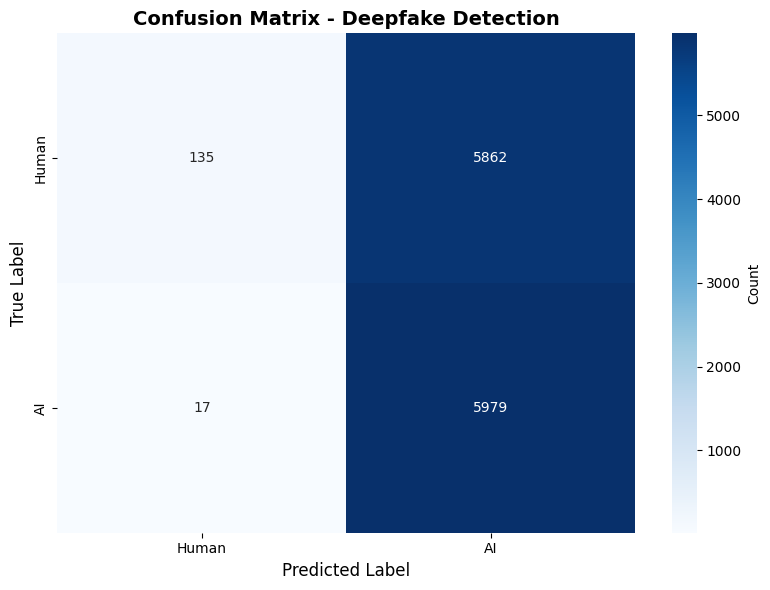

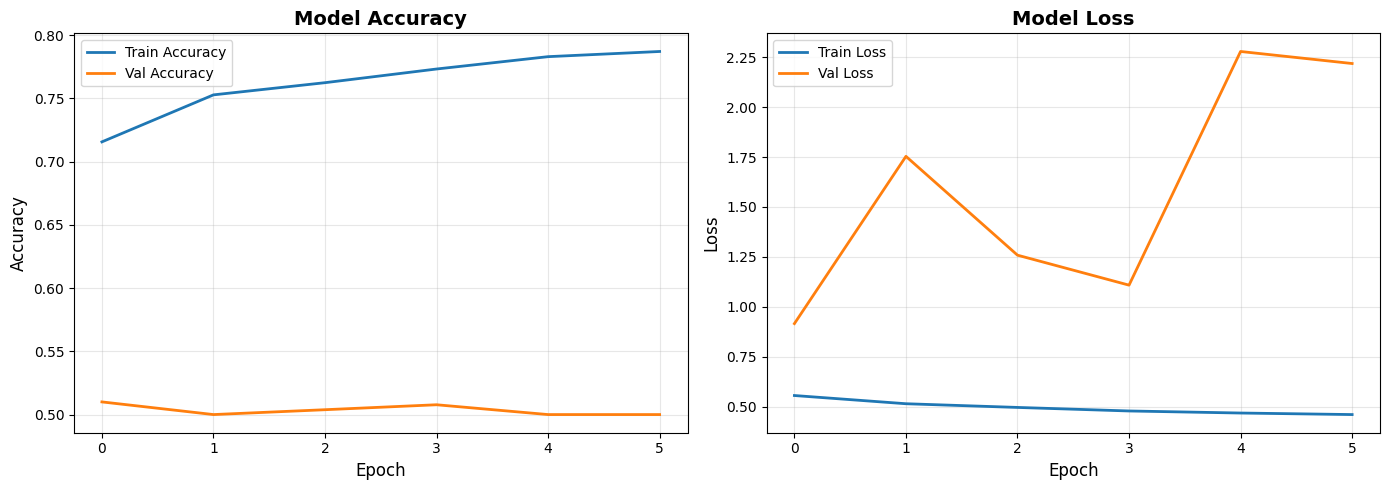


✓ Evaluation complete!


In [12]:
# Evaluation and Metrics

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("Evaluating model on test set...")

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)

print(f"\n{'='*60}")
print(f"FINAL TEST RESULTS")
print(f"{'='*60}")
print(f"Test Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"{'='*60}\n")

# Generate predictions
print("Generating predictions...")
y_pred_prob = model.predict(test_dataset, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_data['label'].values

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Human', 'AI']))

# Confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Human', 'AI'],
            yticklabels=['Human', 'AI'],
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - Deepfake Detection', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Evaluation complete!")

### Sample Predictions Visualization

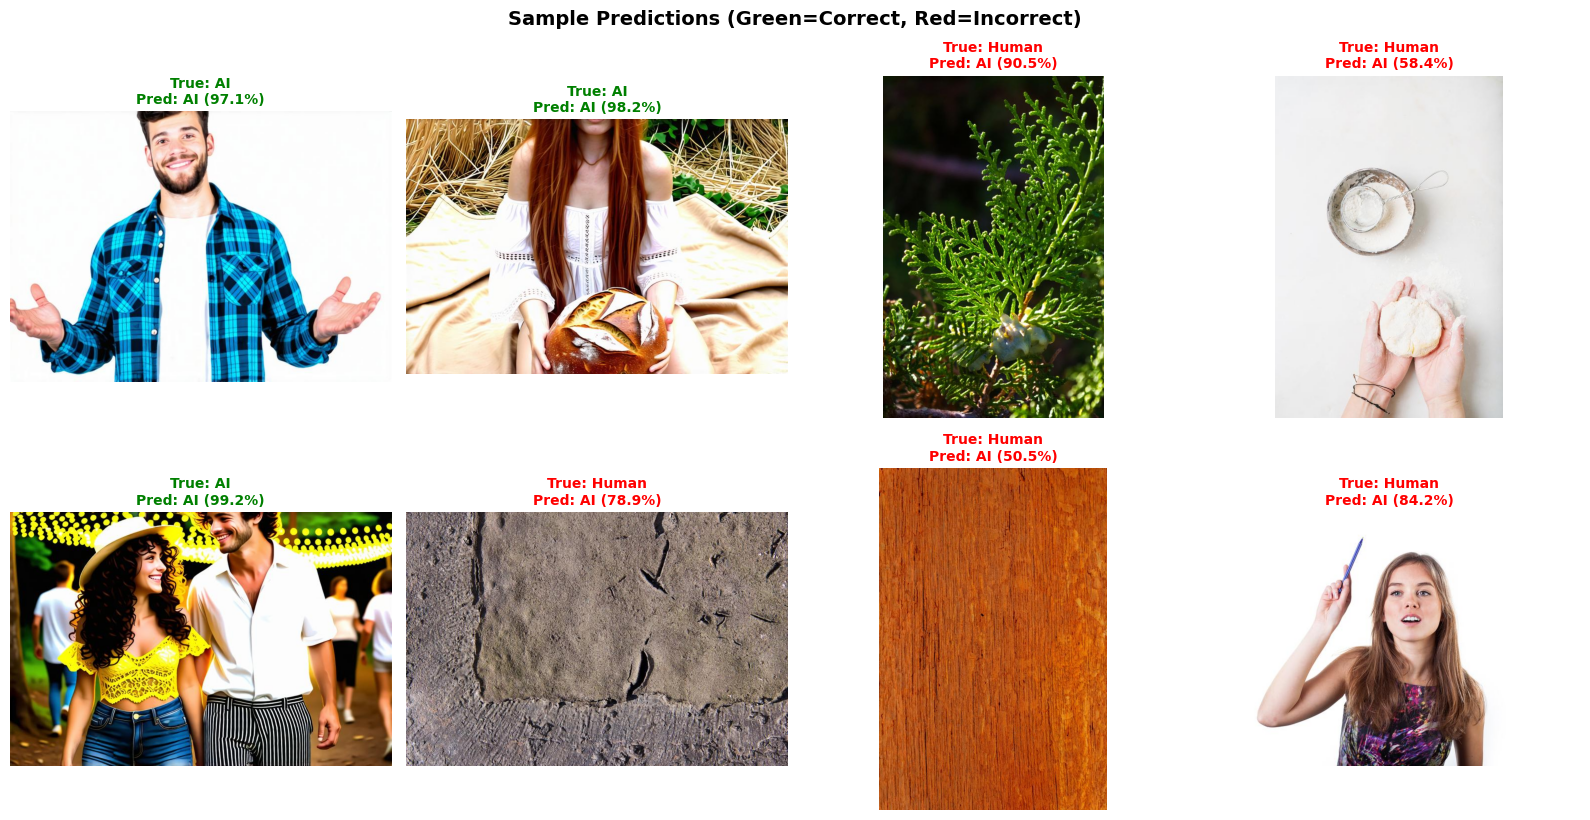

In [13]:
# Visualize sample predictions
import random
from PIL import Image

def show_predictions(num_samples=8):
    """Display random test images with predictions"""
    sample_indices = random.sample(range(len(test_data)), num_samples)

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()

    class_names = ['Human', 'AI']

    for idx, sample_idx in enumerate(sample_indices):
        # Get image and label
        img_path = test_data.iloc[sample_idx]['file_path']
        true_label = test_data.iloc[sample_idx]['label']
        pred_label = y_pred[sample_idx]
        confidence = y_pred_prob[sample_idx][pred_label] * 100

        # Load and display image
        img = Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].axis('off')

        # Set title with color coding
        is_correct = true_label == pred_label
        color = 'green' if is_correct else 'red'
        title = f"True: {class_names[true_label]}\nPred: {class_names[pred_label]} ({confidence:.1f}%)"
        axes[idx].set_title(title, fontsize=10, color=color, fontweight='bold')

    plt.tight_layout()
    plt.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.show()

show_predictions(num_samples=8)

### Save Final Model

In [ ]:
# Save the trained model
model_save_path = "/kaggle/working/deepfake_detector_final.keras"
model.save(model_save_path)
print(f"✓ Model saved to: {model_save_path}")

# Save model in TFLite format for mobile deployment (optional)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

tflite_path = "/kaggle/working/deepfake_detector.tflite"
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)
print(f"✓ TFLite model saved to: {tflite_path}")

# Model size comparison
import os
keras_size = os.path.getsize(model_save_path) / (1024*1024)
tflite_size = os.path.getsize(tflite_path) / (1024*1024)
print(f"\nModel sizes:")
print(f"  Keras:  {keras_size:.2f} MB")
print(f"  TFLite: {tflite_size:.2f} MB (for mobile deployment)")

✓ Model saved to: /kaggle/working/deepfake_detector_final.keras
Saved artifact at '/tmp/tmpe7h0sxub'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_240')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  136684653169744: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float16, name=None)
  136684653170512: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float16, name=None)
  136686283071440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136686283071632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136686283072400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136686357741392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136686283074128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136686283074320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136686283076432: TensorSpec(shape=(), dtype=tf.resource, name=None)
